In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!nvidia-smi

Fri Feb  3 13:49:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!ln -s /content/gdrive/My\ Drive/ /mydrive

In [4]:
%cd /mydrive/X-Rays/

/content/gdrive/My Drive/X-Rays


In [5]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [6]:
# Defining the constants
train_dir = '/content/gdrive/My Drive/X-Rays/dataset/train_images/train_images/'
test_dir = '/content/gdrive/My Drive/X-Rays/dataset/test_images/test_images/'
csv_file = '/content/gdrive/My Drive/X-Rays/dataset/labels_train.csv'
batch_size = 16

# Reading the train labels from CSV file
df = pd.read_csv(csv_file)
# Converting the class_id column to string
df['class_id'] = df['class_id'].astype(str)
df.head()

,file_name,class_id
0,img_4358977458434011046.jpg,1
1,img_5224016757187192130.jpg,2
2,img_3065202206106254707.jpg,2
3,img_6304894865561547174.jpg,1
4,img_3371338542810939877.jpg,2


In [7]:
# Creating a mapping of class labels to class names
class_labels = {0: 'No Disease', 1: 'Bacterial Pneumonia', 2: 'Viral Pneumonia'}

# Initializing the base model
base_model = DenseNet121(weights='imagenet', include_top=False)

# Adding a custom classifier on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compiling the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

29084464/29084464 [==============================] - 0s 0us/step


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
# Using ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Creating the train generator
train_generator = train_datagen.flow_from_dataframe(df, directory=train_dir, x_col='file_name', y_col='class_id', class_mode='categorical', target_size=(224,224), batch_size=batch_size)

# Using ImageDataGenerator for data augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

# Creating the test generator
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224,224),
                                                  batch_size=batch_size,
                                                  class_mode=None,
                                                  shuffle=False)

Found 4672 validated image filenames belonging to 3 classes.
Found 0 images belonging to 0 classes.


In [9]:
# Using early stopping to prevent overfitting and underfitting
early_stopping = EarlyStopping(monitor='train_loss', patience=10, verbose=1)
checkpoint = ModelCheckpoint('model.h5', save_best_only=True, save_weights_only=True)

# Training the model
history = model.fit_generator(train_generator, 
                              steps_per_epoch=len(train_generator), 
                              epochs=20, 
                              validation_data=test_generator, 
                              validation_steps=len(test_generator), 
                              callbacks=[early_stopping, checkpoint])

<ipython-input-9-4770a0f70278>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/20
292/292 [==============================] - ETA: 0s - loss: 0.5696 - accuracy: 0.7676

292/292 [==============================] - 1023s 3s/step - loss: 0.5696 - accuracy: 0.7676
Epoch 2/20
292/292 [==============================] - ETA: 0s - loss: 0.4745 - accuracy: 0.8084

292/292 [==============================] - 90s 307ms/step - loss: 0.4745 - accuracy: 0.8084
Epoch 3/20
292/292 [==============================] - ETA: 0s - loss: 0.4100 - accuracy: 0.8273

292/292 [==============================] - 89s 303ms/step - loss: 0.4100 - accuracy: 0.8273
Epoch 4/20
292/292 [==============================] - ETA: 0s - loss: 0.3831 - accuracy: 0.8408

292/292 [==============================] - 89s 305ms/step - loss: 0.3831 - accuracy: 0.8408
Epoch 5/20
292/292 [==============================] - ETA: 0s - loss: 0.3526 - accuracy: 0.8538

292/292 [==============================] - 89s 305ms/step - loss: 0.3526 - accuracy: 0.8538
Epoch 6/20
292/292 [==============================] - ETA: 0s - loss: 0.3357 - accuracy: 0.8639

292/292 [==============================] - 90s 307ms/step - loss: 0.3357 - accuracy: 0.8639
Epoch 7/20
292/292 [==============================] - ETA: 0s - loss: 0.3015 - accuracy: 0.8793

292/292 [==============================] - 89s 305ms/step - loss: 0.3015 - accuracy: 0.8793
Epoch 8/20
292/292 [==============================] - ETA: 0s - loss: 0.2895 - accuracy: 0.8810

292/292 [==============================] - 88s 302ms/step - loss: 0.2895 - accuracy: 0.8810
Epoch 9/20
292/292 [==============================] - ETA: 0s - loss: 0.2587 - accuracy: 0.8923

292/292 [==============================] - 89s 306ms/step - loss: 0.2587 - accuracy: 0.8923
Epoch 10/20
292/292 [==============================] - ETA: 0s - loss: 0.2421 - accuracy: 0.9043

292/292 [==============================] - 89s 306ms/step - loss: 0.2421 - accuracy: 0.9043
Epoch 11/20
292/292 [==============================] - ETA: 0s - loss: 0.2218 - accuracy: 0.9127

292/292 [==============================] - 89s 305ms/step - loss: 0.2218 - accuracy: 0.9127
Epoch 12/20
292/292 [==============================] - ETA: 0s - loss: 0.1944 - accuracy: 0.9270

292/292 [==============================] - 89s 306ms/step - loss: 0.1944 - accuracy: 0.9270
Epoch 13/20
292/292 [==============================] - ETA: 0s - loss: 0.1832 - accuracy: 0.9324

292/292 [==============================] - 90s 307ms/step - loss: 0.1832 - accuracy: 0.9324
Epoch 14/20
292/292 [==============================] - ETA: 0s - loss: 0.1674 - accuracy: 0.9371

292/292 [==============================] - 90s 307ms/step - loss: 0.1674 - accuracy: 0.9371
Epoch 15/20
292/292 [==============================] - ETA: 0s - loss: 0.1594 - accuracy: 0.9381

292/292 [==============================] - 90s 308ms/step - loss: 0.1594 - accuracy: 0.9381
Epoch 16/20
292/292 [==============================] - ETA: 0s - loss: 0.1587 - accuracy: 0.9390

292/292 [==============================] - 90s 308ms/step - loss: 0.1587 - accuracy: 0.9390
Epoch 17/20
292/292 [==============================] - ETA: 0s - loss: 0.1374 - accuracy: 0.9478

292/292 [==============================] - 89s 306ms/step - loss: 0.1374 - accuracy: 0.9478
Epoch 18/20
292/292 [==============================] - ETA: 0s - loss: 0.1322 - accuracy: 0.9546

292/292 [==============================] - 90s 306ms/step - loss: 0.1322 - accuracy: 0.9546
Epoch 19/20
292/292 [==============================] - ETA: 0s - loss: 0.1180 - accuracy: 0.9533

292/292 [==============================] - 90s 307ms/step - loss: 0.1180 - accuracy: 0.9533
Epoch 20/20
292/292 [==============================] - ETA: 0s - loss: 0.1070 - accuracy: 0.9606

292/292 [==============================] - 90s 307ms/step - loss: 0.1070 - accuracy: 0.9606


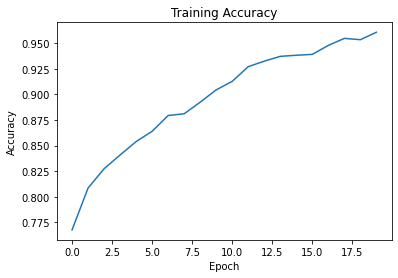

In [10]:
# Plot the training accuracy 
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


In [13]:
# Evaluating the model on the test data
test_loss, test_acc = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print("Test Accuracy: {:.4f}".format(test_acc))

<ipython-input-13-e401e6d17259>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)


ValueError: ignored

In [14]:
# Plotting the test accuracy and test loss
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

KeyError: ignored

In [ ]:
# Loading the best weights from the training
model.load_weights('model.h5')

# Making predictions on test images
test_generator.reset()
predictions = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)

predictions

In [ ]:
# Getting the class with maximum probability for each image
predicted_class_id = np.argmax(predictions, axis=1)

# Creating a list of file names in the test directory
file_names = [f.split('/')[-1] for f in test_generator.filenames]

# Creating a dataframe with the file names and predicted class labels
result = pd.DataFrame({'file_name': file_names, 'predicted_class_id': predicted_class_id})

result

In [ ]:
# Mapping the class labels to class names
result['predicted_class_id'] = result['predicted_class_id'].map(class_labels)

# Saving the predictions as a CSV file
result.to_csv('/content/gdrive/My Drive/X-Rays/dataset/predictions.csv', index=False)